# Задание №3 (2 балла)

## Описание

Загрузите датасет с информацией о сердечных болезнях и их индикаторах – [ Heart Disease Health Indicators Dataset](https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset/data).  
Он содержит данные по результатам опроса, проведенного в 1985 году, в нем описана выборка респондентов:

- Приведена разметка наличия проблем с сердцем: `HeartDiseaseorAttack`
- Приведена **21 характеристика** респондента о его соц-дем положении и здоровье
- Датасет сам по себе уже довольно чистый, поэтому позволяет работать с данными в их сыром виде.
- Он содержит **253 680 наблюдений**, среди которых у **23 893** респондентов присутствовало сердечное заболевание.
- То есть присутствует несильный, но некий **имбаланс классов**.

### Постановка задачи
Допустим, вы заинтересованы в подготовке модели, которая могла бы помочь врачам идентифицировать склонных к сердечным заболеваниям пациентов. Подготовить такую модель вы решили на предоставленном датасете.

В прикрепленных практических материалах для вас уже подготовлен **скрипт**, позволяющий оценить модель на этих данных.  
Но в демонстрации используется несколько переменных, вам же потребуется **весь датасет**.

---

## Задачи

1. Используя материалы для **лекции №2**, обучите модель **логистической регрессии** на данных о сердечных заболеваниях на **всех** предоставленных в датасете факторах.
   - Можно использовать настройку `class_weight='balanced'`.

2. Подготовьте:
   - **Classification report**
   - **Confusion matrix**
   - **График распределения плотности предсказанных скоров** модели по классам 0 и 1.

3. Дайте развернутые комментарии по полученным результатам:
   - О чем вам говорят значения метрик **Precision** и **Recall**?
   - Как можно трактовать значения метрик **F1-macro, ROC-AUC**?

4. Если бы за 1 месяц к вам на осмотр пришло **100 человек** и вы ставили диагноз **«склонность к сердечным болезням»** только по модели, то:
   - В среднем **скольким из них** вы бы поставили диагноз **корректно**?
   - **Скольким ошибочно**?
   - **Скольких потенциальных больных упустили**?

5. Как вы считаете, **насколько полученная вами модель хороша** для применения на практике для определения склонных к заболеваниям пациентов?


---

In [133]:
# Подключим нужные для базовых операций библиотеки
import seaborn as sb
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Подключим пакеты для использования OLS метода и тестов
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Подгрузим полезные функции
from utils import *

# Сделаем автоподгрузку всех изменений при перепрогонке ячейки
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
%reload_ext autoreload

In [3]:
dt_logit = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')

In [5]:
dt_logit.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


### 1. Используя материалы для **лекции №2**, обучите модель **логистической регрессии** на данных о сердечных заболеваниях на **всех** предоставленных в датасете факторах.
Подготовьте:
   - **Classification report**
   - **Confusion matrix**
   - **График распределения плотности предсказанных скоров** модели по классам 0 и 1.

(array([229787.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  23893.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

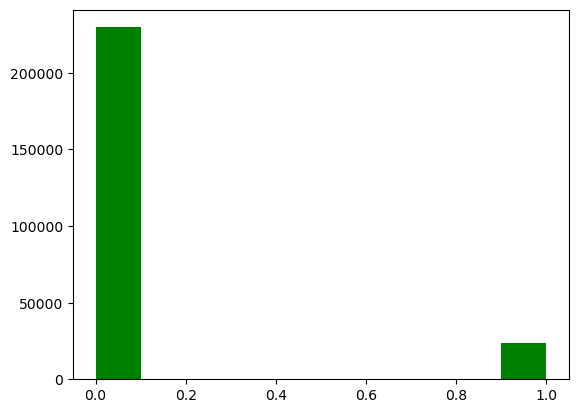

In [33]:
plt.hist(dt_logit['HeartDiseaseorAttack'], color='green')

Явно имеем дело с дизбалансов (imbalance) классов.

#### Предлагаю для начала посмотреть на простую реализацию через statsmodels (без регуляризации и без балансировки классов).

Просто посмотрим на условный baseline.

Optimization terminated successfully.
         Current function value: 0.238483
         Iterations 8
                            Logit Regression Results                            
Dep. Variable:     HeartDiseaseorAttack   No. Observations:               253680
Model:                            Logit   Df Residuals:                   253660
Method:                             MLE   Df Model:                           19
Date:                  Sat, 01 Mar 2025   Pseudo R-squ.:                  0.2359
Time:                          15:41:50   Log-Likelihood:                -60498.
converged:                         True   LL-Null:                       -79178.
Covariance Type:              nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -7.9273      0.102    -77.390      0.000      -8.128      -7.727
High

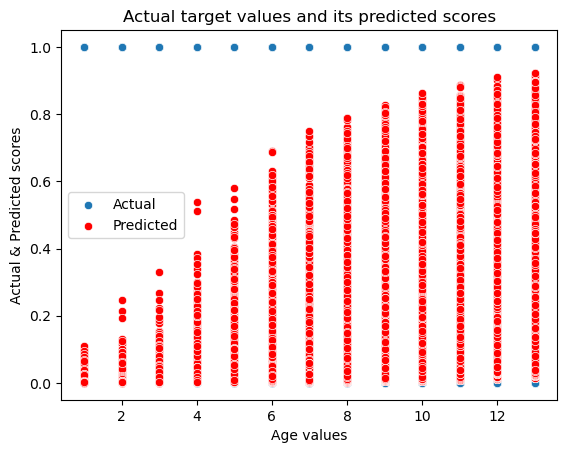

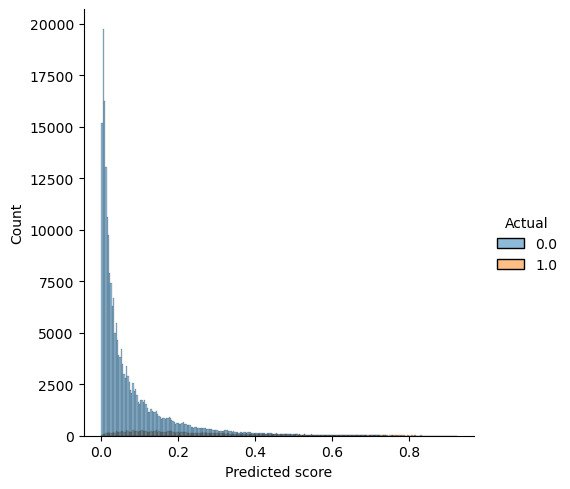

Predicted,0,1
Actual,,
0.000000,227235,2552
1.000000,20858,3035


In [37]:
# Обучим Logit модель Statsmodels
dt_logit, model_logit = train_binary(dt_logit, 
                                     target='HeartDiseaseorAttack', 
                                     feature_names=['HighBP', 
                                                    'HighChol', 
                                                    'CholCheck', 
                                                    'BMI', 
                                                    'Smoker', 
                                                    'Stroke', 
                                                    'Diabetes', 'PhysActivity', 'Fruits', 
                                                    'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 
                                                    'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 
                                                    'Income'], 
                                     plot_feature='Age', ###
                                     model_type='logit', 
                                     pkg='statsmodels')

### Что можем сказать?

- Приемлемый псевдо-R-квадрат;
- BMI, Fruits, AnyHealthcare, PhysHlth, Education - влияние регрессоров не является статистически значимым. Полагаю, что пока что оставляем, но в идеале было бы неплохо посмотреть на метрики моделей без включения регрессоров или хотя бы части из них. Так или иначе, скорее всего, мы снижаем смещение оценок за счет добавления данных регрессоров.
- Хороший ROC AUC score: 0.847, **НО!**
- Мы достаточно плохо работаем с интересующими нас метками, а именно положительным классом "1". Лишь 54% положительных объектов классифицируются как действительно положительный класс (precision) - есть много "ложноположительных" срабатываний; доля правильно найденных положительных объектов среди всех объектов положительного класса 13% - много "ложноотрицательных" срабатываний (**фактически, отрицательные метки "0" тянут вниз наши метрики, когда нас на самом деле интересует именно предикт по положительной метке**).       


### Идея: а давайте посмотрим на baseline реализацию с помощью sklearn!

Увеличил число итераций для поиска оптимума, так как солвер не мог сойтись на оптимальных весах


 ================================================== TRAIN RESULTS ================================================== 

ROC AUC score: 0.847

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95    229787
         1.0       0.54      0.13      0.21     23893

    accuracy                           0.91    253680
   macro avg       0.73      0.56      0.58    253680
weighted avg       0.88      0.91      0.88    253680



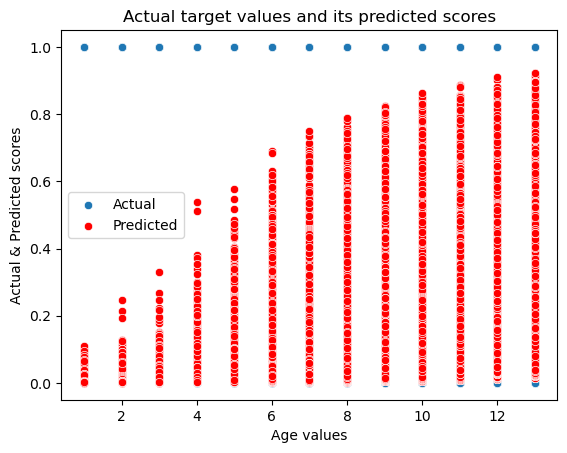

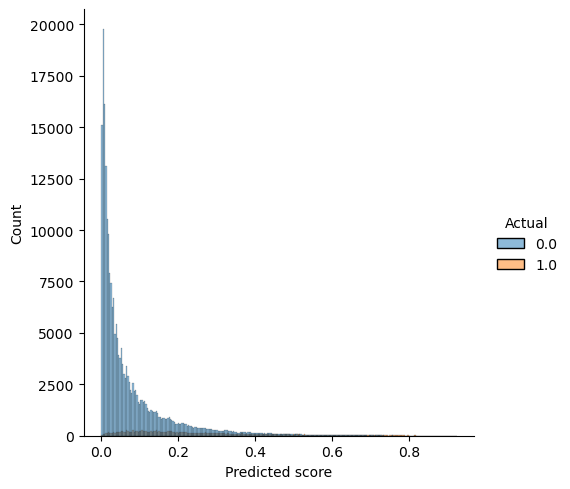

Predicted,0.000000,1.000000
Actual,,
0.000000,227239,2548
1.000000,20866,3027


In [46]:
# Обучим Logit модель
dt_logit, model_logit = train_binary(dt_logit, 
                                     target='HeartDiseaseorAttack', 
                                     feature_names=['HighBP', 
                                                    'HighChol', 
                                                    'CholCheck', 
                                                    'BMI', 
                                                    'Smoker', 
                                                    'Stroke', 
                                                    'Diabetes', 'PhysActivity', 'Fruits', 
                                                    'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 
                                                    'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 
                                                    'Income'], 
                                     plot_feature='Age', ###
                                     model_type='logit', 
                                     pkg='sklearn')

### Выводы:
- Что-то разница практически не заметна...
- Сбалансируем классы!
- Увеличим число итераций для лучшей сходимости модели;
- Изменим метод градиентной оптимизации на SAGa


 ================================================== TRAIN RESULTS ================================================== 

ROC AUC score: 0.847

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85    229787
         1.0       0.25      0.80      0.38     23893

    accuracy                           0.75    253680
   macro avg       0.61      0.77      0.61    253680
weighted avg       0.90      0.75      0.80    253680



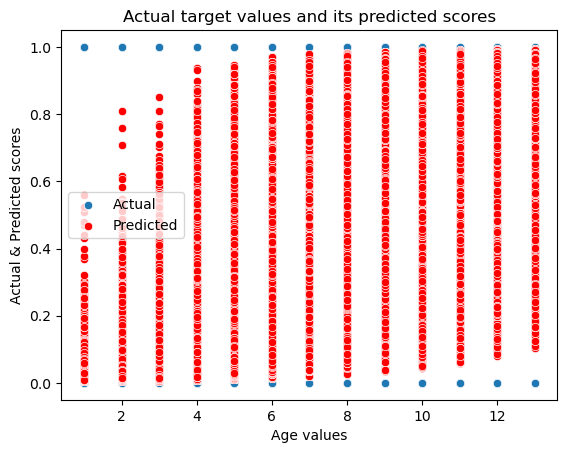

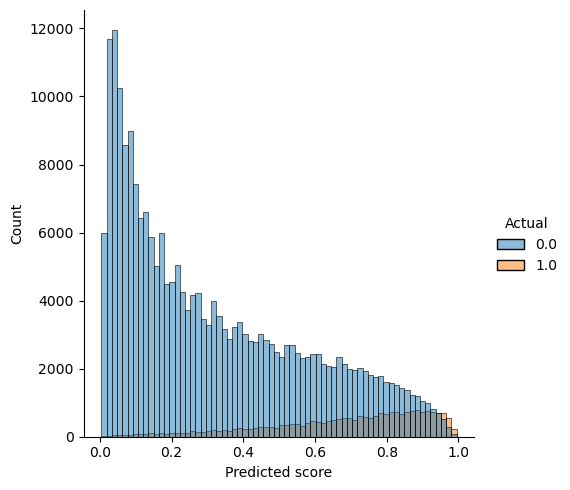

Predicted,0.000000,1.000000
Actual,,
0.000000,171758,58029
1.000000,4893,19000


In [69]:
# Обучим Logit модель
dt_logit, model_logit = train_binary(dt_logit, 
                                     target='HeartDiseaseorAttack', 
                                     feature_names=['HighBP', 
                                                    'HighChol', 
                                                    'CholCheck', 
                                                    'BMI', 
                                                    'Smoker', 
                                                    'Stroke', 
                                                    'Diabetes', 'PhysActivity', 'Fruits', 
                                                    'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 
                                                    'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 
                                                    'Income'], 
                                     plot_feature='Age', ###
                                     model_type='logit', 
                                     pkg='sklearn',
                                     class_weight='balanced')

### Выводы:
- Мы отлично улучшили полноту - наиболее интересную для нас метрику! То есть, мы теперь лучше выявляем, сколько американцев действительно "had heart disease". На precision, кажется, в задаче можно меньше обращать внимание - главное поднять показатели по предиктам наименее превалирующего класса "1", чем работать с калибровкой precision, которая больше про то, сколько класса "1" предсказано верно (лучше выявить у здоровых пациентов проблему, чем недовыявить у на самом деле имеющих проблемы)

### А можно ли еще лучше?
- Попробовал (не вывел результат) убрать незначимые признаки - ухудшило recall на 1%.
- Давайте думать про регуляризацию;
- Добавляем в utils затюненную вариацию модели, которая будет искать мне оптимальные гиперпараметры из заданного множества (верхнеуровнево пробегаемся по параметрам регуляризации, типе превалирующей регуляризации, солверу;
- Вышло слегка криво, но результаты есть, смотрим:

In [118]:
# Обучим Logit модель
dt_logit, model_logit = train_binary(dt_logit, 
                                     target='HeartDiseaseorAttack', 
                                     feature_names=['HighBP', 
                                                    'HighChol', 
                                                    'CholCheck', 
                                                    'BMI', 
                                                    'Smoker', 
                                                    'Stroke', 
                                                    'Diabetes', 'PhysActivity', 'Fruits', 
                                                    'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 
                                                    'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 
                                                    'Income'], 
                                     plot_feature='None',
                                     model_type='logit', 
                                     pkg='tuned_sklearn',
                                     class_weight='balanced')

D:\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

Лучшие параметры: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 23.357214690901213}


NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

#### Лучшие параметры: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 23.357214690901213}


 ================================================== TRAIN RESULTS ================================================== 

ROC AUC score: 0.847

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85    229787
         1.0       0.25      0.80      0.38     23893

    accuracy                           0.75    253680
   macro avg       0.61      0.77      0.61    253680
weighted avg       0.90      0.75      0.80    253680



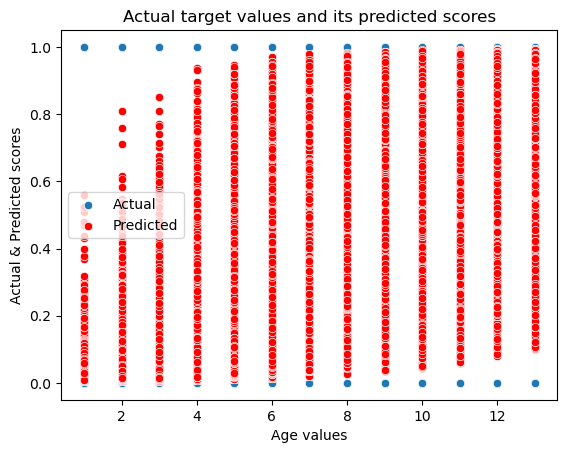

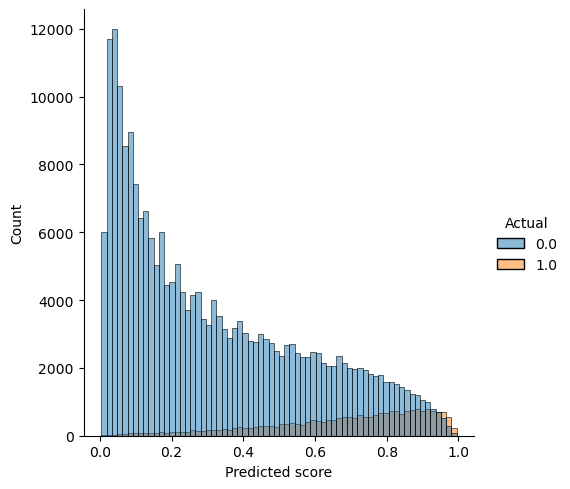

Predicted,0.000000,1.000000
Actual,,
0.000000,171785,58002
1.000000,4898,18995


In [142]:
# Обучим Logit модель
dt_logit, model_logit = train_binary(dt_logit, 
                                     target='HeartDiseaseorAttack', 
                                     feature_names=['HighBP', 
                                                    'HighChol', 
                                                    'CholCheck', 
                                                    'BMI', 
                                                    'Smoker', 
                                                    'Stroke', 
                                                    'Diabetes', 'PhysActivity', 'Fruits', 
                                                    'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 
                                                    'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 
                                                    'Income'], 
                                     plot_feature='Age',
                                     model_type='logit', 
                                     pkg='optimal_tuned_sklearn',
                                     class_weight='balanced')

### Вывод: не получается побить предыдущую спецификацию...

Давайте вернемся к модели, которую мы рассматривали перед этим и сделаем релевантные выводы. Не закрепляю случайное число, результаты +- одни и те же (разница на 1 предикт класса местами).

С отсечкой не буду разбираться, оставим **0.5**.


 ================================================== TRAIN RESULTS ================================================== 

ROC AUC score: 0.847

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85    229787
         1.0       0.25      0.80      0.38     23893

    accuracy                           0.75    253680
   macro avg       0.61      0.77      0.61    253680
weighted avg       0.90      0.75      0.80    253680



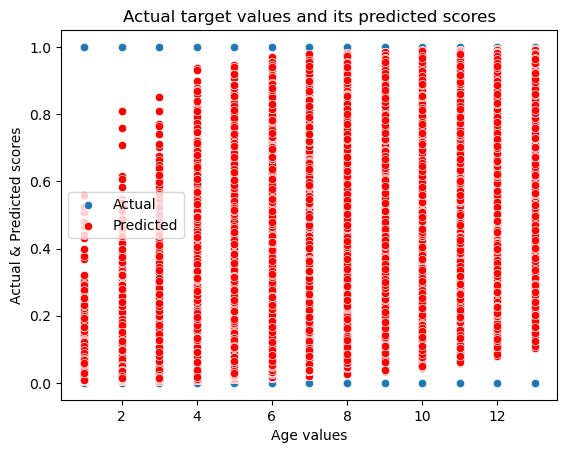

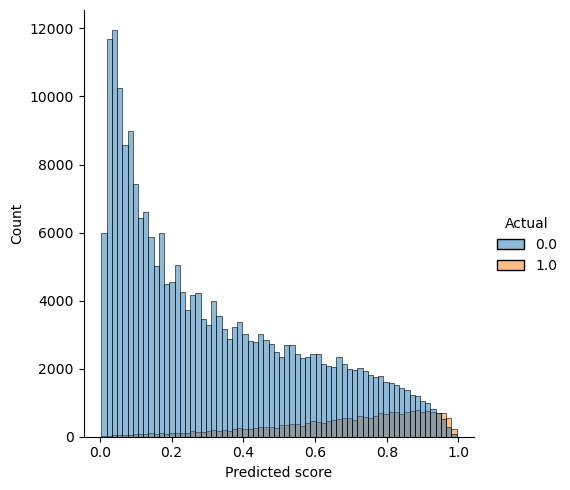

Predicted,0.000000,1.000000
Actual,,
0.000000,171759,58028
1.000000,4893,19000


In [144]:
# Обучим Logit модель
dt_logit, model_logit = train_binary(dt_logit, 
                                     target='HeartDiseaseorAttack', 
                                     feature_names=['HighBP', 
                                                    'HighChol',
                                                    'CholCheck', 
                                                    'BMI', 
                                                    'Smoker', 
                                                    'Stroke', 
                                                    'Diabetes', 'PhysActivity', 'Fruits', 
                                                    'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 
                                                    'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 
                                                    'Income'], 
                                     plot_feature='Age', ###
                                     model_type='logit', 
                                     pkg='sklearn',
                                     class_weight='balanced')

### 3. Дайте развернутые комментарии по полученным результатам:
   - О чем вам говорят значения метрик **Precision** и **Recall**?
   - Как можно трактовать значения метрик **F1-macro, ROC-AUC**?

| **Метрика**       | **Класс 0 (Здоровые)** | **Класс 1 (Больные)** | **Средние значения** |
|-------------------|----------------------|----------------------|----------------------|
| **Precision**     | 0.97                 | 0.25                 | —                    |
| **Recall**        | 0.75                 | 0.80                 | 0.77 (macro avg)     |
| **F1-score**      | 0.85                 | 0.38                 | 0.61 (macro avg)     |
| **Support**       | 229,787              | 23,893               | 253,680 (всего)      |
| **Accuracy**      | —                    | —                    | **0.75**             |
| **ROC AUC Score** | —                    | —                    | **0.847**           |


- **Precision** и **Recall** - за счет балансировки классов мы теперь имеем recall `0.8` по положительному классу. Пожертвовав precision для recall, наши предикты теперь неплохо бы работали в реальной жизни. Как уже обратил внимание ранее - "Мы отлично улучшили полноту - наиболее интересную для нас метрику! То есть, мы теперь лучше выявляем, сколько американцев действительно "had heart disease". На precision, кажется, в задаче можно меньше обращать внимание - главное поднять показатели по предиктам наименее превалирующего класса "1", чем работать с калибровкой precision, которая больше про то, сколько класса "1" предсказано верно (лучше выявить у здоровых пациентов проблему, чем недовыявить у на самом деле имеющих проблемы)"
- F1-macro
- **ROC-AUC 0.847** - Если взять случайного больного и случайного здорового пациента, модель в 84.7% случаев правильно скажет, кто из них болен. Достаточно хороший показатель.
- **F1-macro 0.61** - не сказал бы, что показатель хорош, но это как раз потому, что мы сбалансировали модель на большее предсказывание ложных положительных классов.

4. Если бы за 1 месяц к вам на осмотр пришло **100 человек** и вы ставили диагноз **«склонность к сердечным болезням»** только по модели, то:
   - В среднем **скольким из них** вы бы поставили диагноз **корректно**?
   - **Скольким ошибочно**?
   - **Скольких потенциальных больных упустили**?

   - В среднем **скольким из них** вы бы поставили диагноз **корректно**?

(TP + TN) / (TP + TN + FP + FN) = Accuracy = 0.75 * 100 = **75** пациентов - корректно бы получили свой диагноз.

   - **Скольким ошибочно**?
       
(FP + FN) / (TP + TN + FP + FN) = Error Rate = 1 - Accuracy = 100 - 75 = **25** пациентов - **НЕ**корректно бы получили свой диагноз.

   - **Скольких потенциальных больных упустили**?

FN / (TP + TN + FP + FN) = Total False Negative Rate = (4893) / (19 000 + 171 759 + 58 028 + 4893) * 100 = 1.92 ~ **2** пациента - потенциальных больных упустили

### 5. Как вы считаете, **насколько полученная вами модель хороша** для применения на практике для определения склонных к заболеваниям пациентов?

Я считаю, что модель является приемлемой, хоть и требует значимых улучшений. Trade-off между precision и recall является вынужденной мерой, но определение того, каким именно должен быть данный trade-off - вопрос уже требующий наличия индустриальной экспретизы.